In [5]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
import os
import numpy as  np
import matplotlib.pyplot as plt
from PIL import  Image
import pandas
from matplotlib.pyplot import imshow


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.models import Model
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers

#
from Models import encoder_model, decoder_model, VAE, load_model_vae
from Data import get_image_data
#to reduce the tensorflow messages
# tf.get_logger().setLevel('WARNING')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('ERROR')

#  Model

In [8]:
# Sampling layer
class Sampling(layers.Layer):
    "used to sample a vector in latent space with learned mean - z_mean and (log) variance - z_log_var"
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch_size = tf.shape(z_mean)[0]
        vec_len = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch_size, vec_len))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



In [9]:
def encoder_model(input_shape, filters, dense_layer_dim, latent_dim):
    # Create input layer
    encoder_layers_dim = []
    encoder_inputs = keras.Input(shape=input_shape)
    encoder_layers_dim.append(tuple(encoder_inputs.shape[1:]))
    # Add convolutional layers with specified number of filters and activation function
    x = layers.Conv2D(filters[0], (3,3), activation="relu", strides=2, padding="same")(encoder_inputs)
    encoder_layers_dim.append(tuple(x.shape[1:]))
    # x = MaxPooling2D((2, 2), padding="same")(x)
    # Add additional convolutional layers with specified number of filters and activation function
    mid_layers = [layers.Conv2D(f, 3, activation="relu", strides=2, padding="same") for f in filters[1:]]
    for mid_layer in mid_layers:
        x = mid_layer(x)
        encoder_layers_dim.append(tuple(x.shape[1:]))
        # x = MaxPooling2D((2, 2), padding="same")(x)
    
    # Flatten convolutional output to prepare for dense layers
    x = layers.Flatten()(x)
    encoder_layers_dim.append(tuple(x.shape[1:]))
    # Add dense layer with specified number of neurons and activation function
    x = layers.Dense(dense_layer_dim, activation='relu')(x)
    
    # Add output layers for latent space (mean and variance) and sample from this space
    z_mean = layers.Dense(latent_dim, name = "z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder_layers_dim.append(tuple(z.shape[1:]))
    
    # Create encoder model
    return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder'), encoder_layers_dim
test_encoder, encoder_layers_dim = encoder_model(input_shape = (56,56,1), filters=[32, 64], dense_layer_dim=16, latent_dim=2)
test_encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56, 56, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 12544)        0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [10]:
# decoder
def decoder_model(encoder_layers_dim):
    latent_dim = encoder_layers_dim[-1][0]
    dense_layer_dim = encoder_layers_dim[-2][0]
    first_conv_layer_dim = encoder_layers_dim[-3]
    filters = [f[-1] for f in encoder_layers_dim[1:-2]]
    output_layer = encoder_layers_dim[0]

    latent_inputs = keras.Input(shape=(latent_dim,))
    # feed latent vector through a dense layer with ReLU activation
    # note that we apply the first filter in the form of dense and reshape it
    x = layers.Dense(dense_layer_dim, activation="relu")(latent_inputs)
    # reshape output from dense layer to match dimensions of first convolutional layer
    x = layers.Reshape(first_conv_layer_dim)(x)
    # apply series of transpose convolutional layers with ReLU activation and same padding and Upsampling
    mid_layers = [layers.Conv2DTranspose(f, 3, activation="relu", strides=2, padding="same") for f in filters[::-1]]
    for mid_layer in mid_layers:
        x = mid_layer(x)
    
    # apply final convolutional layer with sigmoid activation to output reconstructed image
    decoder_outputs = layers.Conv2DTranspose(output_layer[-1], 3, activation="sigmoid", padding="same")(x)
    
    # create and return Keras model with latent vector as input and reconstructed image as output
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")
test_decoder = decoder_model(encoder_layers_dim)
test_decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 56, 56, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 56, 56, 1)         289       
Total params: 93,313
Trainable params: 93,313
Non-trainable params: 0
_______________________________________________________

In [11]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    def call(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, z, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # z_mean, z_log_var, z = self.encoder(data)
            # reconstruction = self.decoder(z)
            z_mean, z_log_var, z, reconstruction = self(data)
            # reconstruction_loss = tf.reduce_mean(
            #     tf.reduce_sum(
            #         keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            #     )
            # )
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstruction), axis = (1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# data

In [12]:
DATA_DIR =  ['Data'] #[r'C:\Users\kkosara\AutoDRIVE-Nigel-Dataset\data'] Data\test1
OUTPUT_IMAGE_SHAPE = 56
INPUT_SHAPE = (OUTPUT_IMAGE_SHAPE, OUTPUT_IMAGE_SHAPE, 1)
FILTERS = [32, 64]
NUM_CONV_LAYERS = len(FILTERS)
DENSE_LAYER_DIM = 16
LATENT_DIM = 10
BETA = 1.0
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE
LEARNING_RATE = 1e-4
PATIENCE = 10
EPOCHS  = 2
TRAIN_SPLIT = 0.8
LOGDIR = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
GRAYSCALE = True

In [13]:
all_image_paths = get_image_data(DATA_DIR)
image_count = len(all_image_paths)

# Create a dataset from the list of image file paths
dataset = tf.data.Dataset.from_tensor_slices(all_image_paths)

# Shuffle the dataset with a buffer size of 1000 and seed of 42
dataset = dataset.shuffle(buffer_size=1000, seed=42, reshuffle_each_iteration=False)

# Load and preprocess the images
# Function to load and preprocess an image
def load_and_preprocess_image(path=all_image_paths, shape=OUTPUT_IMAGE_SHAPE, grayscale=GRAYSCALE):
    # Load the image file
    image = tf.io.read_file(path)
    # # Decode the image to a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # if grayscale:
        # Convert RGB to grayscale
    image = tf.image.rgb_to_grayscale(image)
    # # Resize the image to the desired size
    image = tf.image.resize(image, [shape, shape])
    # # Normalize the pixel values to be between 0 and 1
    image = tf.cast(image, tf.float32) / 255.0
    print(image.shape)
    return image
dataset = dataset.map(load_and_preprocess_image)


Data
Total number of imges: 155190
(56, 56, 1)


(56, 56, 1)


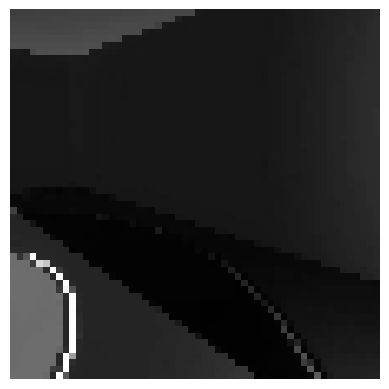

(56, 56, 1)


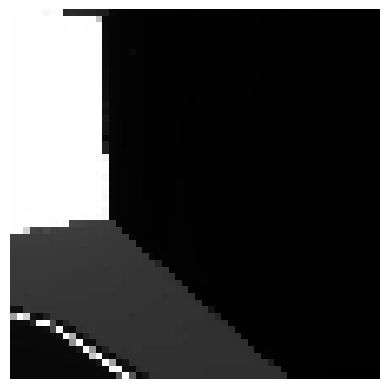

(56, 56, 1)


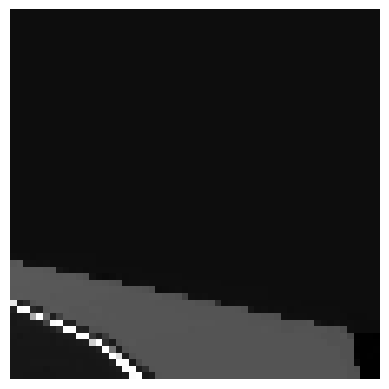

(56, 56, 1)


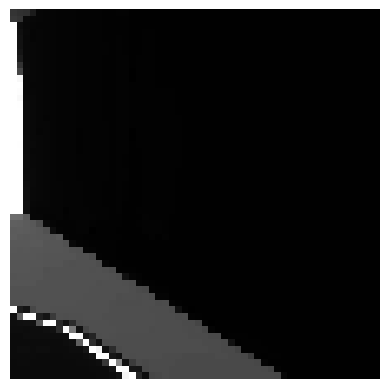

(56, 56, 1)


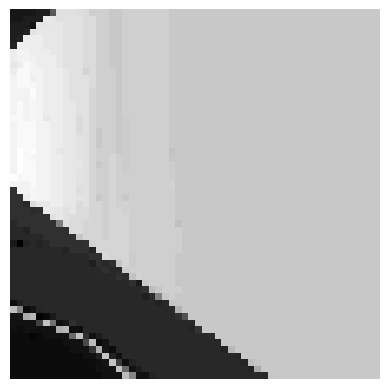

In [14]:
for image in dataset.take(5):
    image_np = image.numpy() # convert to a NumPy array
    print(image.shape)
    # create a PIL Image object from the NumPy array
    # pil_image = Image.fromarray(np.uint8(image_np*255))
    # Display the image using Matplotlib
    plt.imshow(image_np, cmap='gray')
    plt.axis('off')

    # plot the image using matplotlib
    # plt.imshow(pil_image)
    plt.show()

# Train

In [21]:
encoder, encoder_layers_dim = encoder_model(input_shape = INPUT_SHAPE, filters=FILTERS, dense_layer_dim=DENSE_LAYER_DIM, latent_dim=LATENT_DIM)
decoder = decoder_model(encoder_layers_dim)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
# Split the dataset into training and validation sets
train_dataset = dataset.take(int(TRAIN_SPLIT * image_count))
vae_dataset = dataset.take(int((1-TRAIN_SPLIT) * image_count))

# train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
# train_dataset = train_dataset.shuffle(buffer_size=500, seed=42)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)
history = vae.fit(dataset, epochs=300)

Epoch 1/300
1212/1212 [==============================] - 369s 304ms/step - loss: 284.9969 - reconstruction_loss: 276.6299 - kl_loss: 6.3901


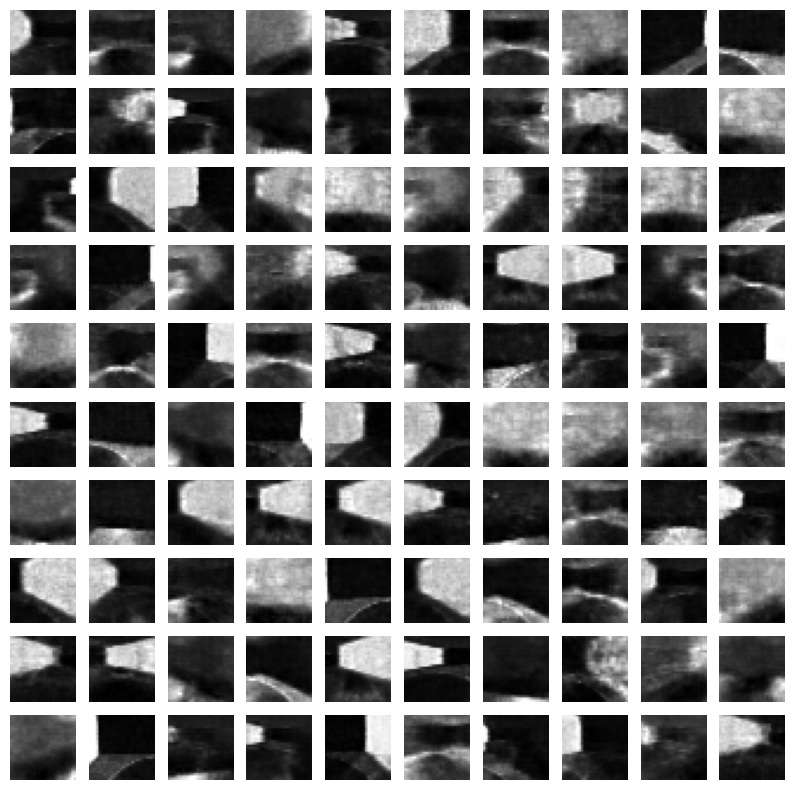

Epoch 2/300
1212/1212 [==============================] - 368s 304ms/step - loss: 284.8652 - reconstruction_loss: 276.4919 - kl_loss: 6.3990


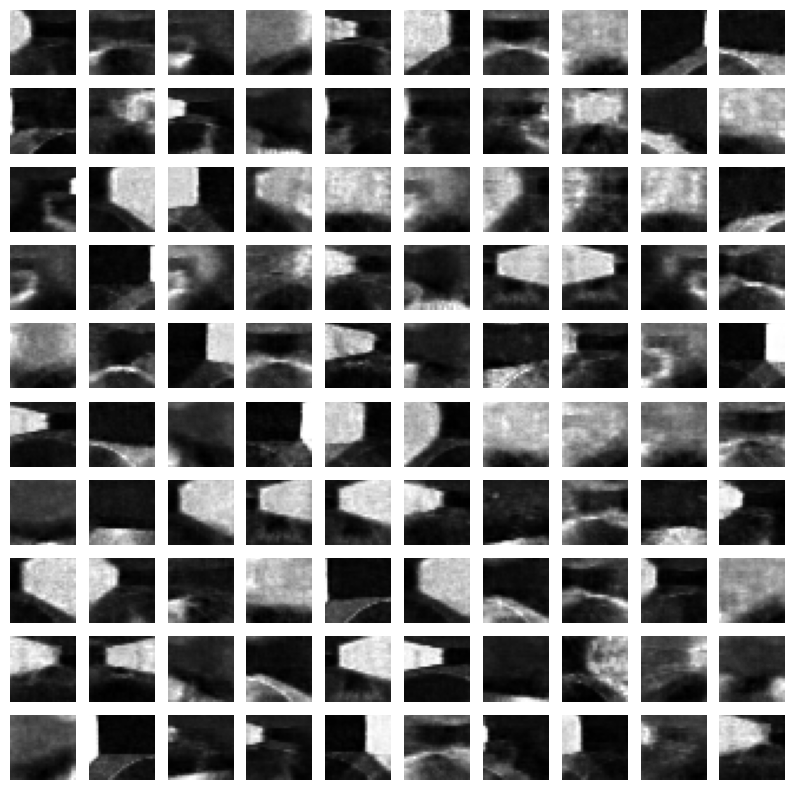

Epoch 3/300
1212/1212 [==============================] - 403s 332ms/step - loss: 284.7568 - reconstruction_loss: 276.3875 - kl_loss: 6.4232


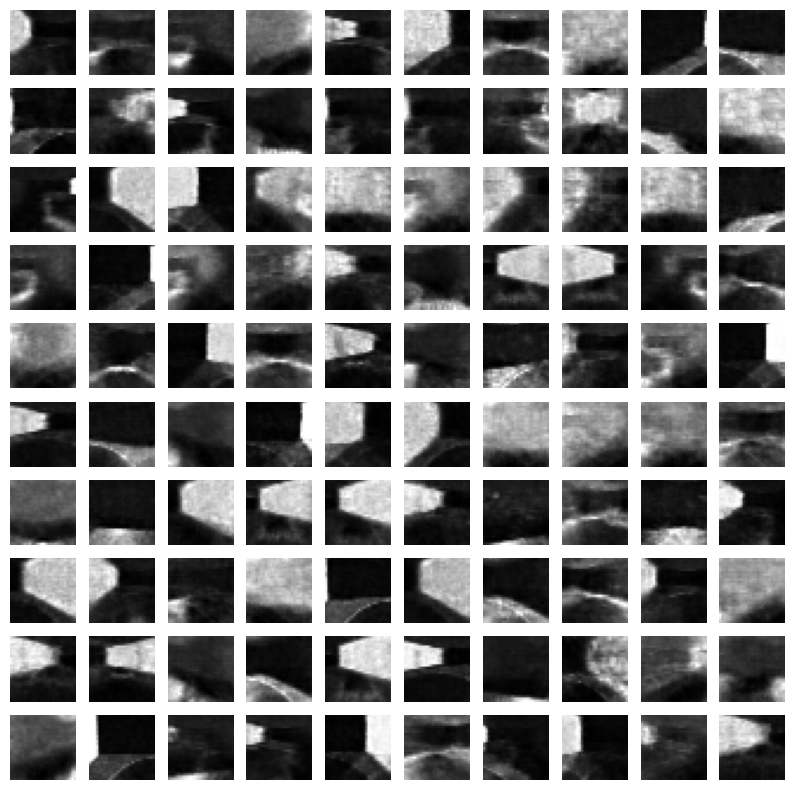

Epoch 4/300
  95/1212 [=>............................] - ETA: 8:46 - loss: 285.6348 - reconstruction_loss: 279.9597 - kl_loss: 6.4123

KeyboardInterrupt: 

In [37]:
class DecodeCallback(tf.keras.callbacks.Callback):
    def __init__(self, vae, test_input):
        self.vae = vae
        self.test_input = test_input

    def on_epoch_end(self, epoch, logs=None):
        # Generate decoded images from the test input
        decoded_imgs = self.vae.decoder.predict(self.test_input)

        # Reshape the decoded images to be 28x28 and convert to grayscale
        decoded_imgs = np.reshape(decoded_imgs, (-1, 28, 28))
        decoded_imgs = np.expand_dims(decoded_imgs, axis=-1)

        # Plot and save the decoded images
        plt.figure(figsize=(10, 10))
        for i in range(decoded_imgs.shape[0]):
            plt.subplot(10, 10, i+1)
            plt.imshow(decoded_imgs[i], cmap='gray')
            plt.axis('off')
        plt.savefig('decoded_images_epoch_{:04d}.png'.format(epoch))
        plt.show()
# Create a test batch of random noise to generate decoded images
test_input = tf.random.normal(shape=(100, 5))

# Create an instance of the DecodeCallback
decode_callback = DecodeCallback(vae, test_input)

# Fit the VAE model with the DecodeCallback
history = vae.fit(dataset, epochs=300, callbacks=[decode_callback])


# Train2 with callbacks

In [18]:
class VAECallback(tf.keras.callbacks.Callback):
    def __init__(self, vae, test_data, n=10):
        self.vae = vae
        self.test_data = test_data
        self.n = n
    def on_epoch_end(self, epoch, logs=None):
        # Select 10 random test images
        idx = np.random.randint(0, self.test_data.shape[0], self.n)
        test_images = self.test_data[idx]

        # Generate predictions for the selected test images
        z_mean, z_log_var, z, decoded_images = self.vae.predict(test_images)

        # Reshape the decoded images to be 28x28 and convert to grayscale
        decoded_images = np.reshape(decoded_images, (-1, 28, 28))
        decoded_images = np.expand_dims(decoded_images, axis=-1)

        # Plot the original and predicted images side by side
        fig, axs = plt.subplots(self.n, 2, figsize=(self.n, 25))
        for i in range(self.n):
            axs[i, 0].imshow(test_images[i].squeeze(), cmap='gray')
            axs[i, 0].axis('off')
            axs[i, 1].imshow(decoded_images[i].squeeze(), cmap='gray')
            axs[i, 1].axis('off')
        plt.savefig('decoded_images_epoch_{:04d}.png'.format(epoch))
        plt.show()
class VAECallbackv2(tf.keras.callbacks.Callback):
    def __init__(self, vae, test_dataset, n=10):
        self.vae = vae
        self.test_dataset = test_dataset
        self.n = n
    def on_epoch_end(self, epoch, logs=None):
        # Generate decoded images from the test input
        test_batch = next(iter(self.test_dataset))
        _, _, _, reconstructed_images = self.vae.predict(test_batch)

        # Rescale pixel values to [0, 1]
        # reconstructed_images = reconstructed_images
        reconstructed_images = np.clip(reconstructed_images, 0.0, 1.0)

        # Plot the original and reconstructed images side by side
        plt.figure(figsize=(10, 20))
        for i in range(10):
            plt.subplot(10, 2, 2*i+1)
            plt.imshow(test_batch[i], cmap='gray')
            plt.axis('off')
            plt.subplot(10, 2, 2*i+2)
            plt.imshow(reconstructed_images[i], cmap='gray')
            plt.axis('off')
        plt.savefig('decoded_images_epoch_{:04d}.png'.format(epoch))
        plt.show()


In [25]:
all_image_paths = get_image_data(DATA_DIR)
image_count = len(all_image_paths)

# Create a dataset from the list of image file paths
dataset = tf.data.Dataset.from_tensor_slices(all_image_paths)

# Shuffle the dataset with a buffer size of 1000 and seed of 42
dataset = dataset.shuffle(buffer_size=1000, seed=42, reshuffle_each_iteration=False)

# Load and preprocess the images
# Function to load and preprocess an image
def load_and_preprocess_image(path=all_image_paths, shape=OUTPUT_IMAGE_SHAPE, grayscale=GRAYSCALE):
    # Load the image file
    image = tf.io.read_file(path)
    # # Decode the image to a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # if grayscale:
        # Convert RGB to grayscale
    image = tf.image.rgb_to_grayscale(image)
    # # Resize the image to the desired size
    image = tf.image.resize(image, [shape, shape])
    # # Normalize the pixel values to be between 0 and 1
    image = tf.cast(image, tf.float32) / 255.0
    print(image.shape)
    return image
dataset = dataset.map(load_and_preprocess_image)
# dataset = dataset.map(load_and_preprocess_image)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)
# Fit the VAE model with the DecodeCallback
encoder, encoder_layers_dim = encoder_model(input_shape = INPUT_SHAPE, filters=FILTERS, dense_layer_dim=DENSE_LAYER_DIM, latent_dim=LATENT_DIM)
decoder = decoder_model(encoder_layers_dim)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae_callback = VAECallbackv2(vae, dataset.take(10))


Data
Total number of imges: 155190
(56, 56, 1)


Epoch 1/300
1213/1213 [==============================] - 357s 290ms/step - loss: 1303.1953 - reconstruction_loss: 1185.6825 - kl_loss: 13.3396


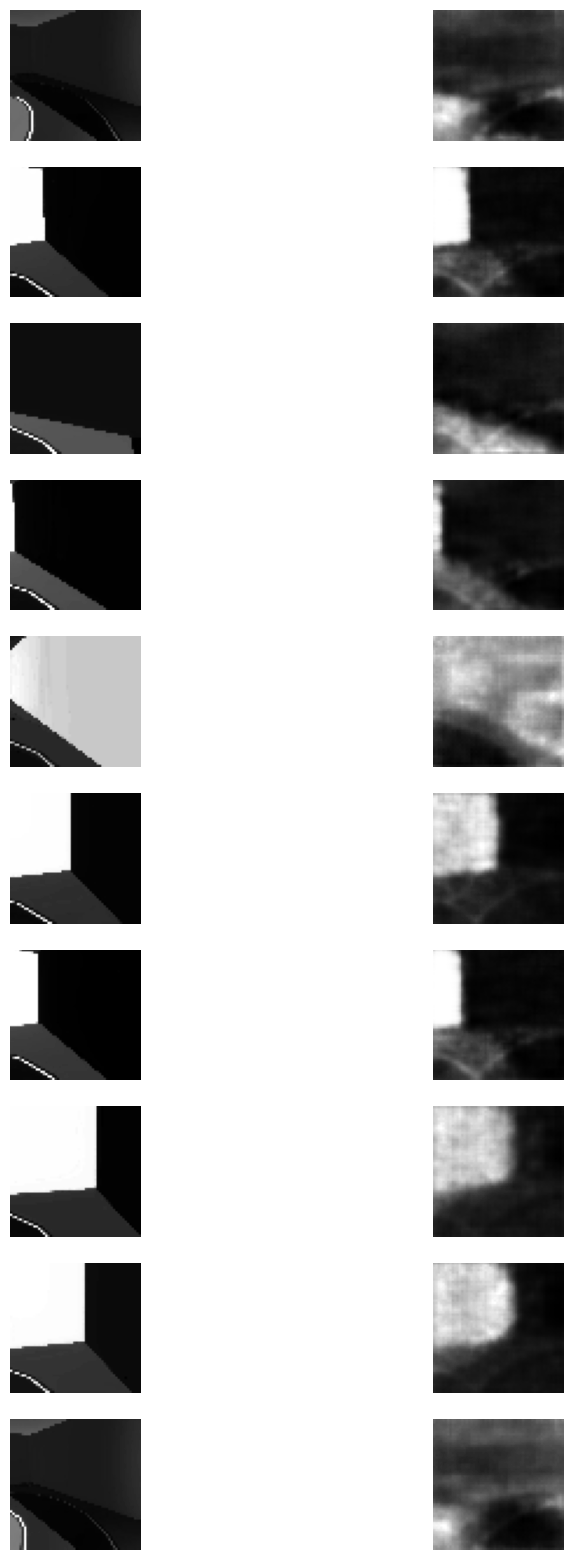

Epoch 2/300
1213/1213 [==============================] - 357s 295ms/step - loss: 1140.2127 - reconstruction_loss: 1113.8661 - kl_loss: 14.2362


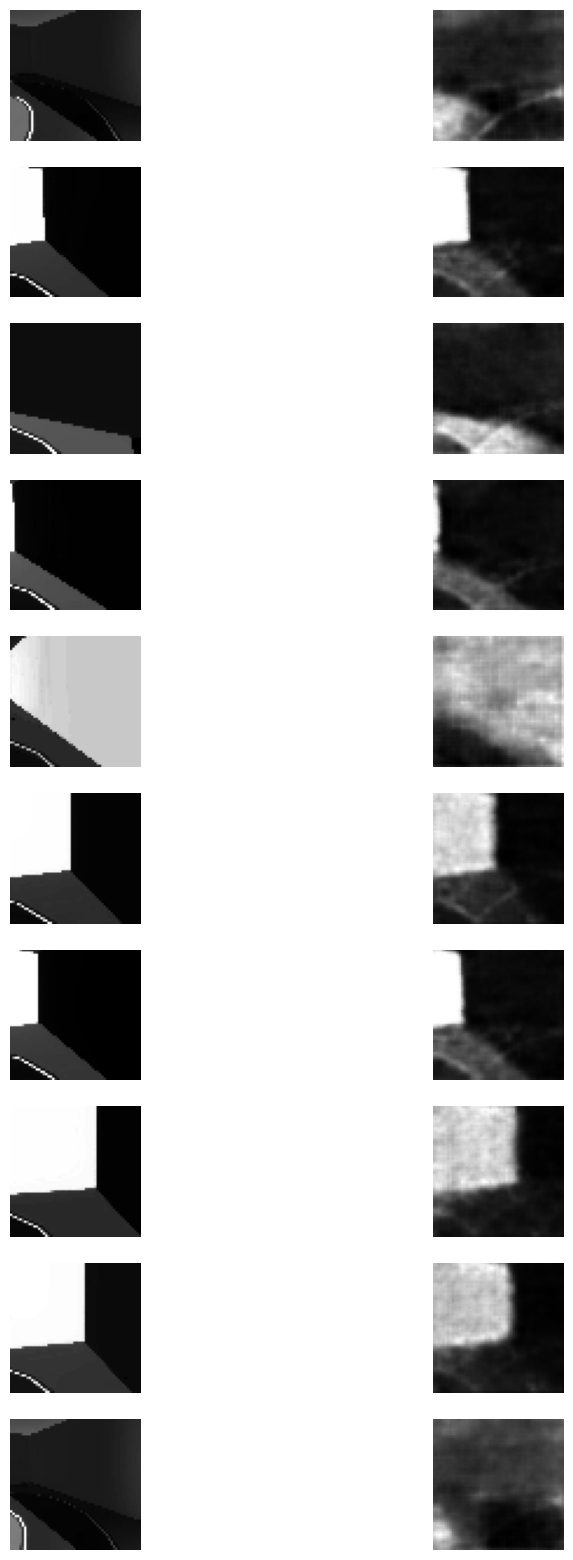

Epoch 3/300
1213/1213 [==============================] - 375s 309ms/step - loss: 1129.2883 - reconstruction_loss: 1106.4017 - kl_loss: 13.1977


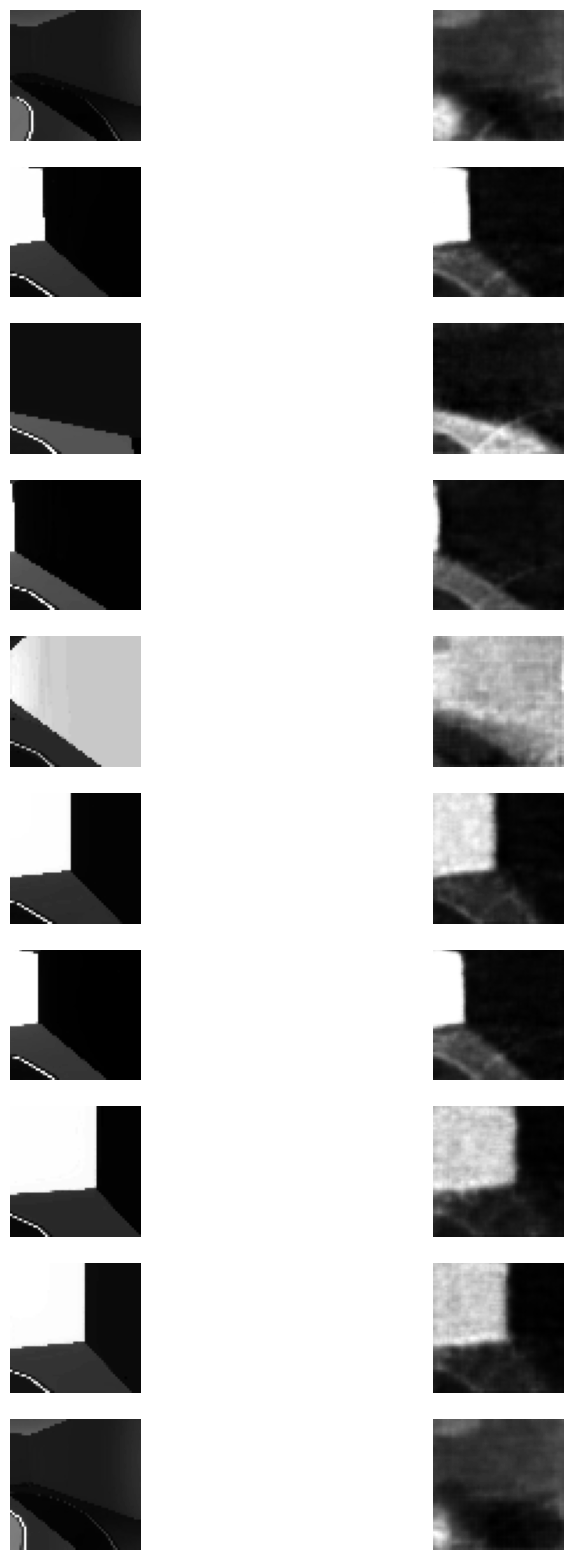

Epoch 4/300
1213/1213 [==============================] - 397s 327ms/step - loss: 1124.3632 - reconstruction_loss: 1102.9407 - kl_loss: 12.5331


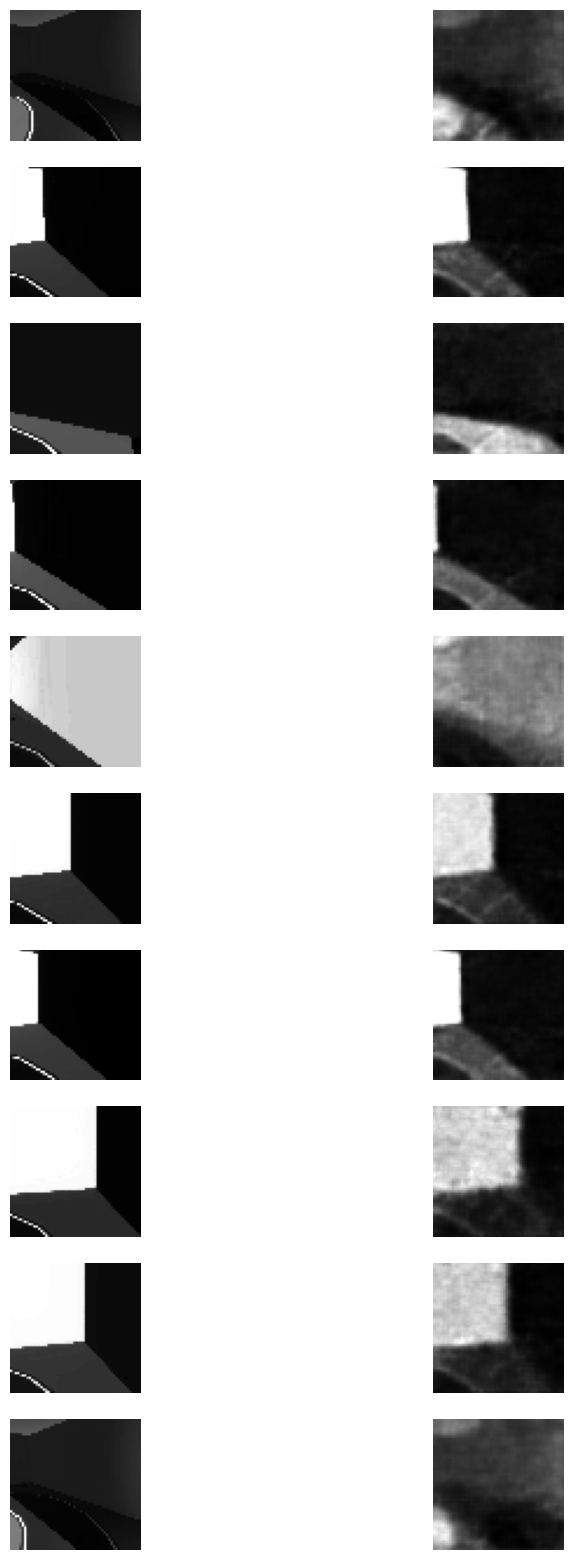

Epoch 5/300
1213/1213 [==============================] - 377s 311ms/step - loss: 1121.3320 - reconstruction_loss: 1100.8152 - kl_loss: 12.1787


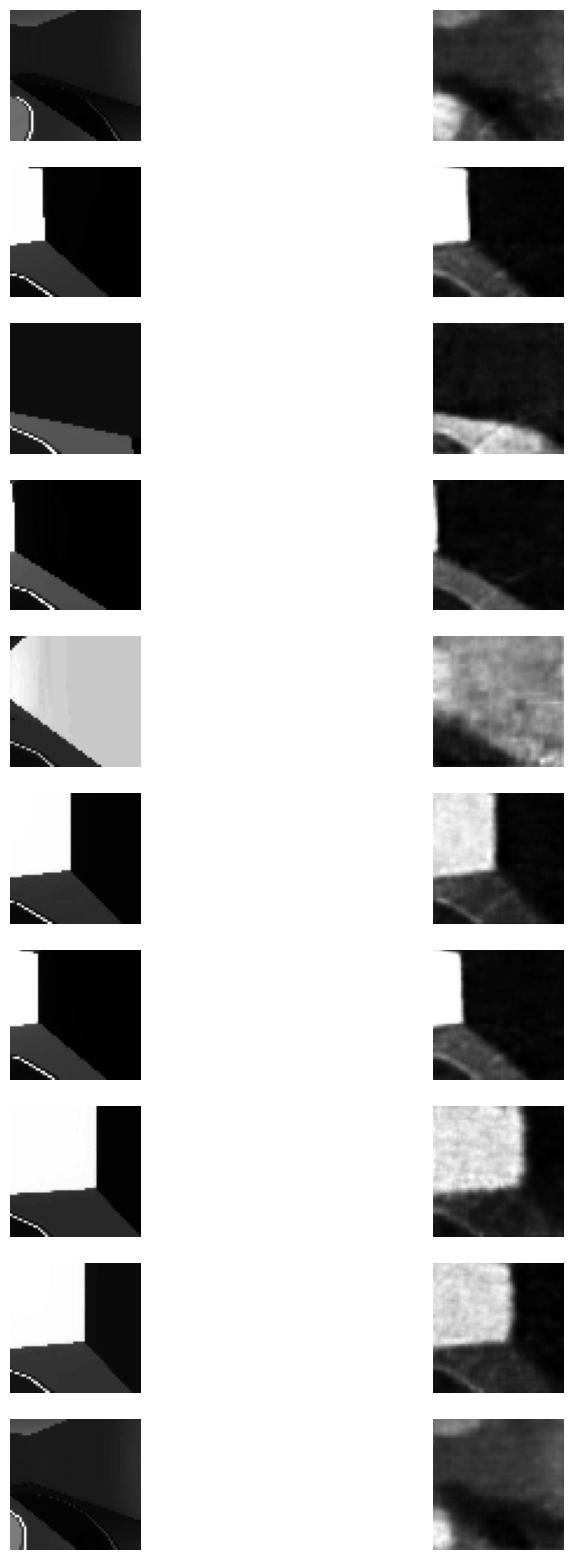

Epoch 6/300
1213/1213 [==============================] - 395s 325ms/step - loss: 1119.6207 - reconstruction_loss: 1099.5176 - kl_loss: 12.1022


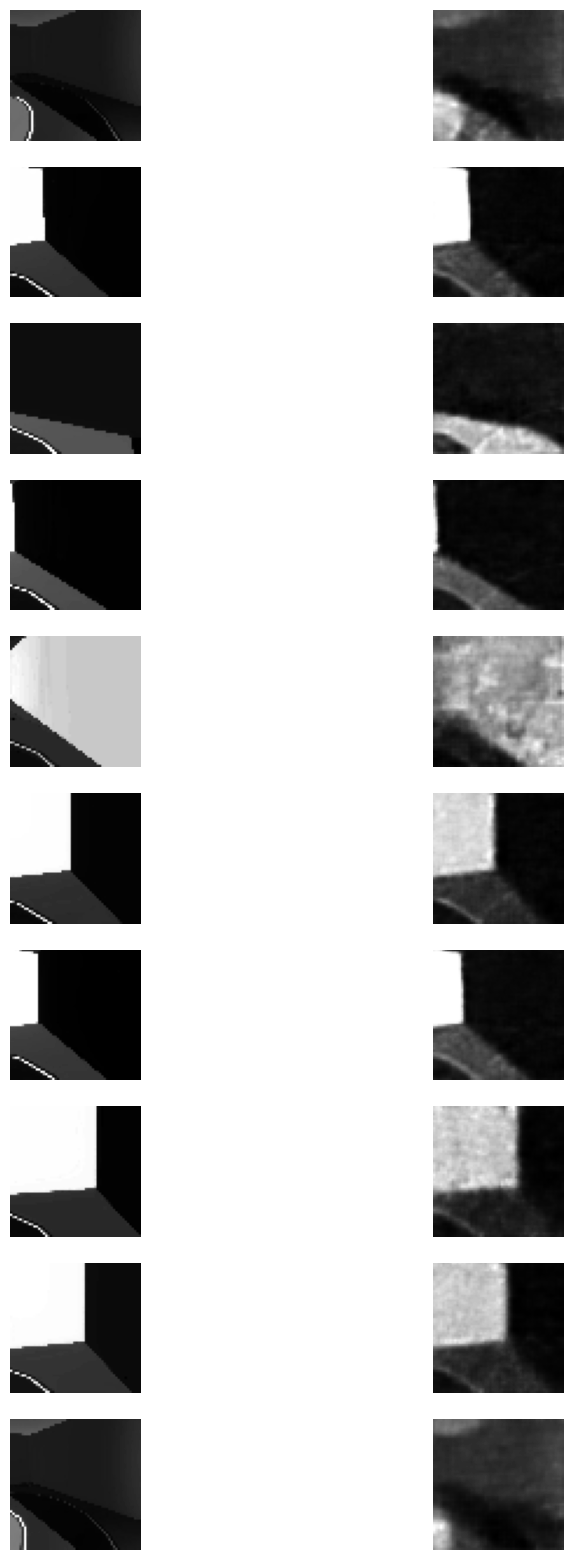

Epoch 7/300
1213/1213 [==============================] - 387s 319ms/step - loss: 1118.6190 - reconstruction_loss: 1098.6346 - kl_loss: 12.0444


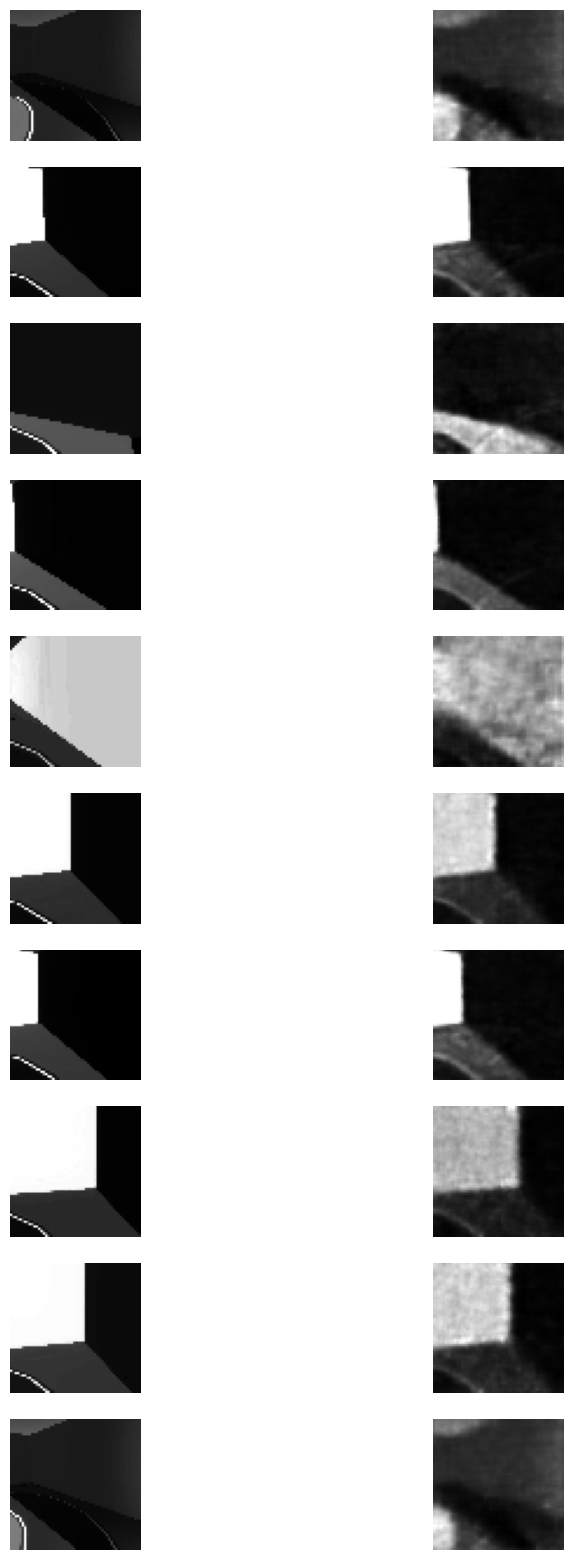

Epoch 8/300
1213/1213 [==============================] - 369s 304ms/step - loss: 1117.7590 - reconstruction_loss: 1097.9515 - kl_loss: 11.9789


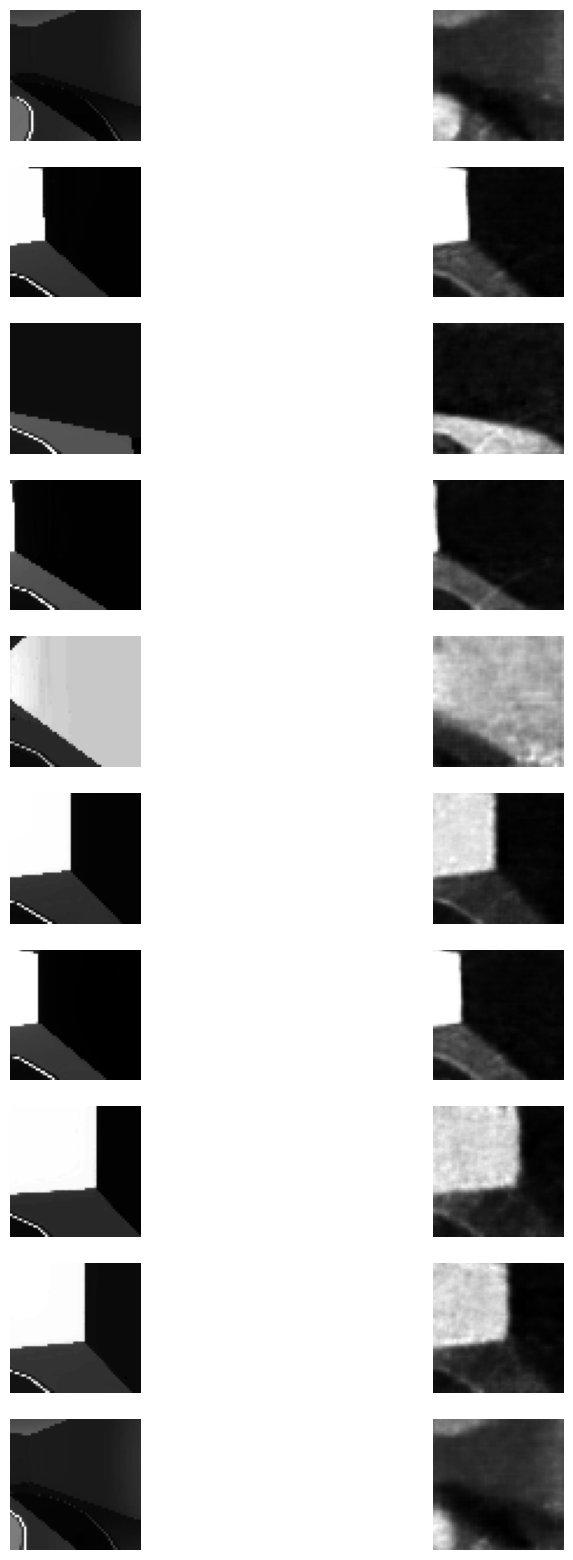

Epoch 9/300
1213/1213 [==============================] - 358s 295ms/step - loss: 1117.0010 - reconstruction_loss: 1097.3270 - kl_loss: 11.9179


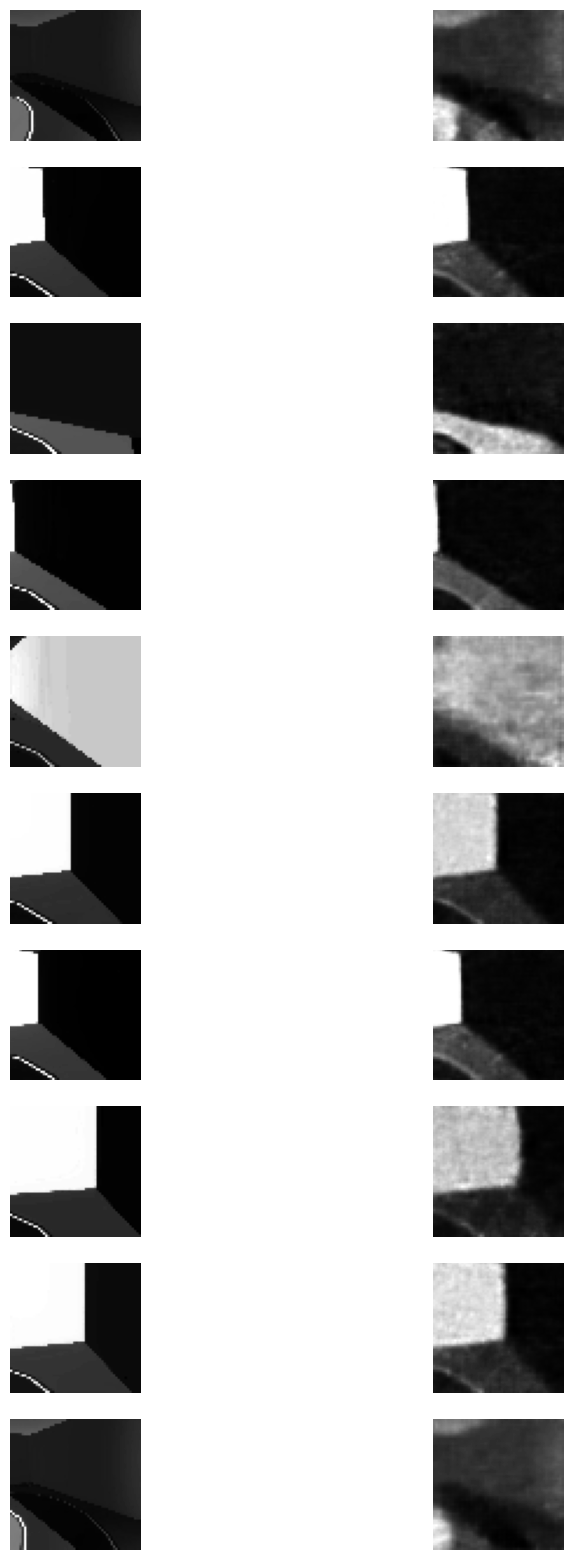

Epoch 10/300
1213/1213 [==============================] - 356s 294ms/step - loss: 1116.3860 - reconstruction_loss: 1096.8240 - kl_loss: 11.8665


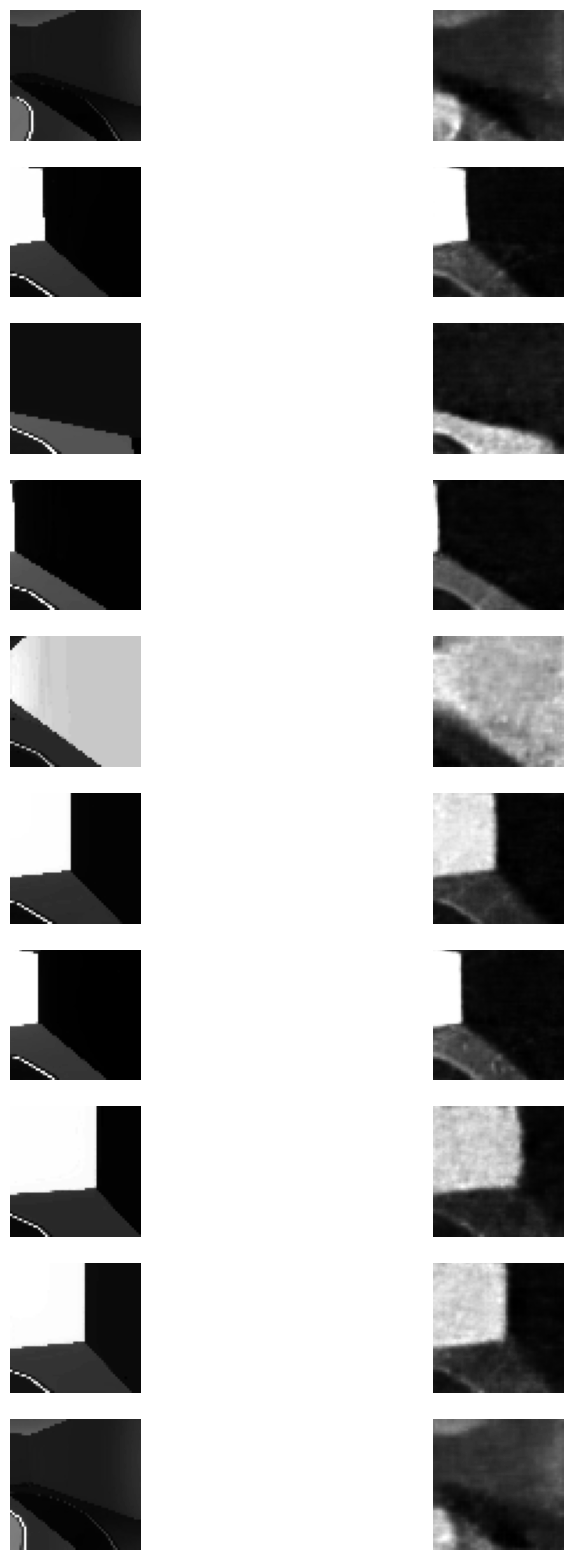

Epoch 11/300
1213/1213 [==============================] - 362s 299ms/step - loss: 1115.7827 - reconstruction_loss: 1096.3628 - kl_loss: 11.8105


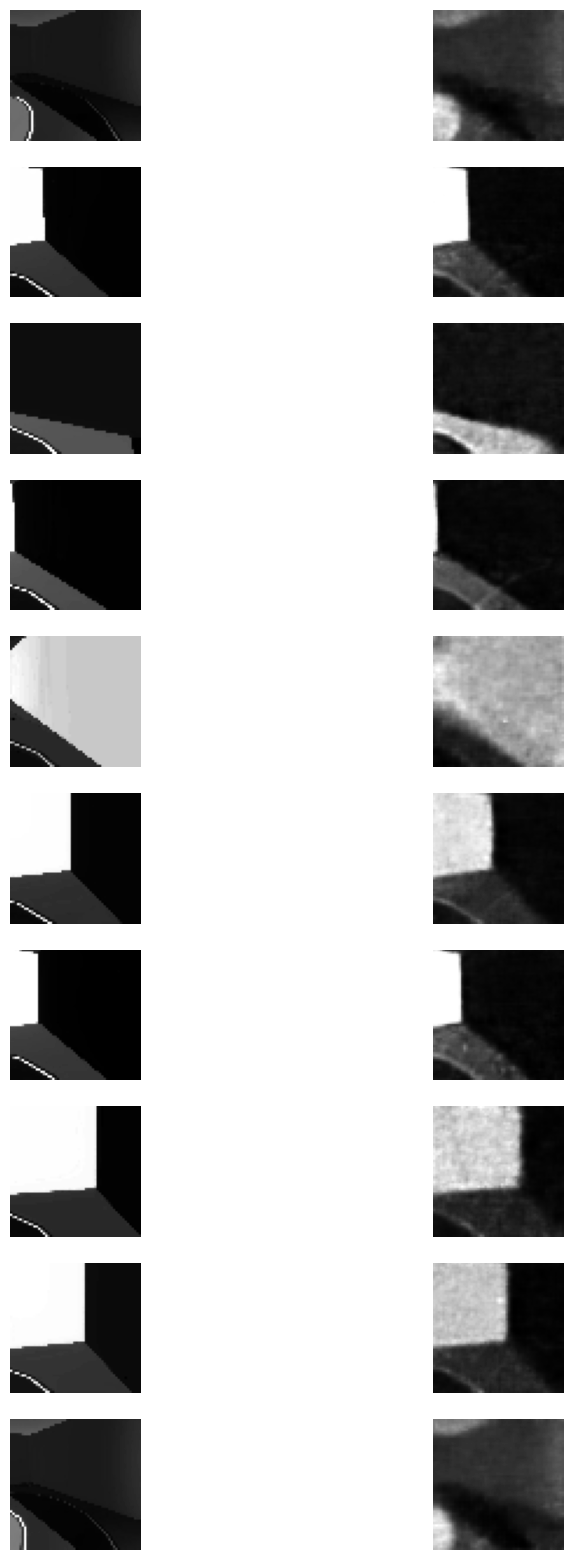

Epoch 12/300
1213/1213 [==============================] - 368s 303ms/step - loss: 1115.3119 - reconstruction_loss: 1095.9913 - kl_loss: 11.7693


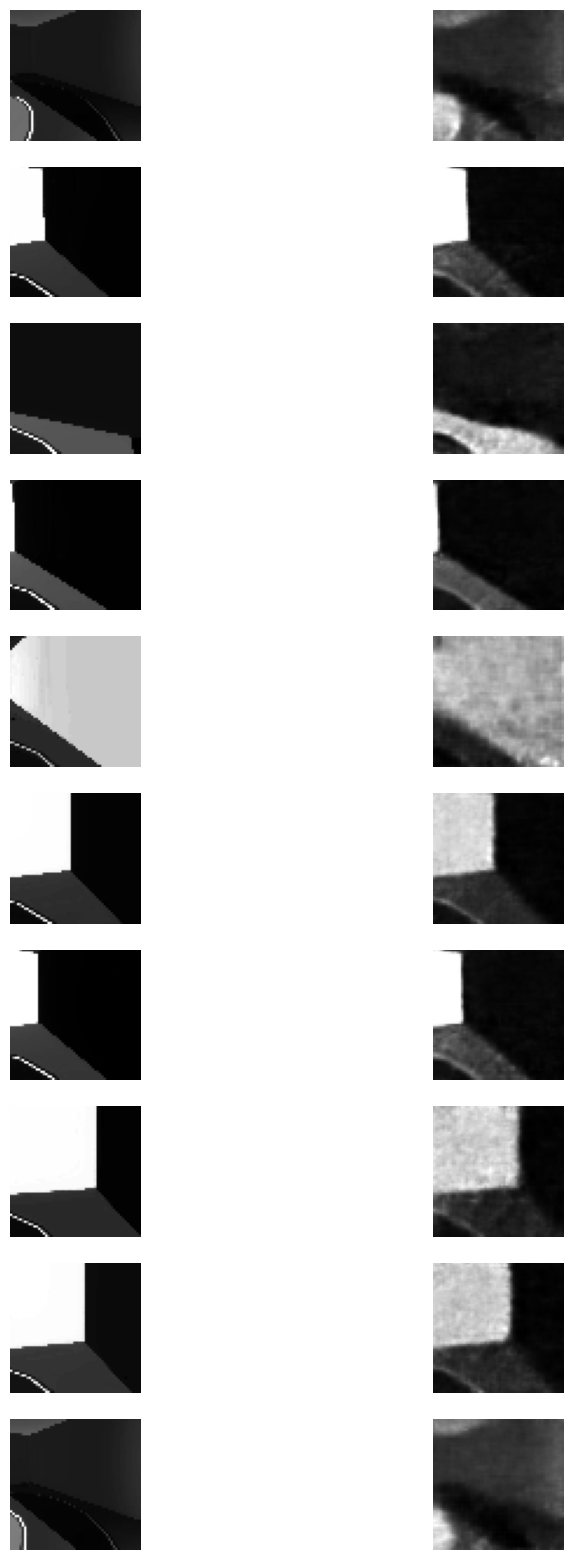

Epoch 13/300
1213/1213 [==============================] - 368s 303ms/step - loss: 1114.9145 - reconstruction_loss: 1095.6239 - kl_loss: 11.7465


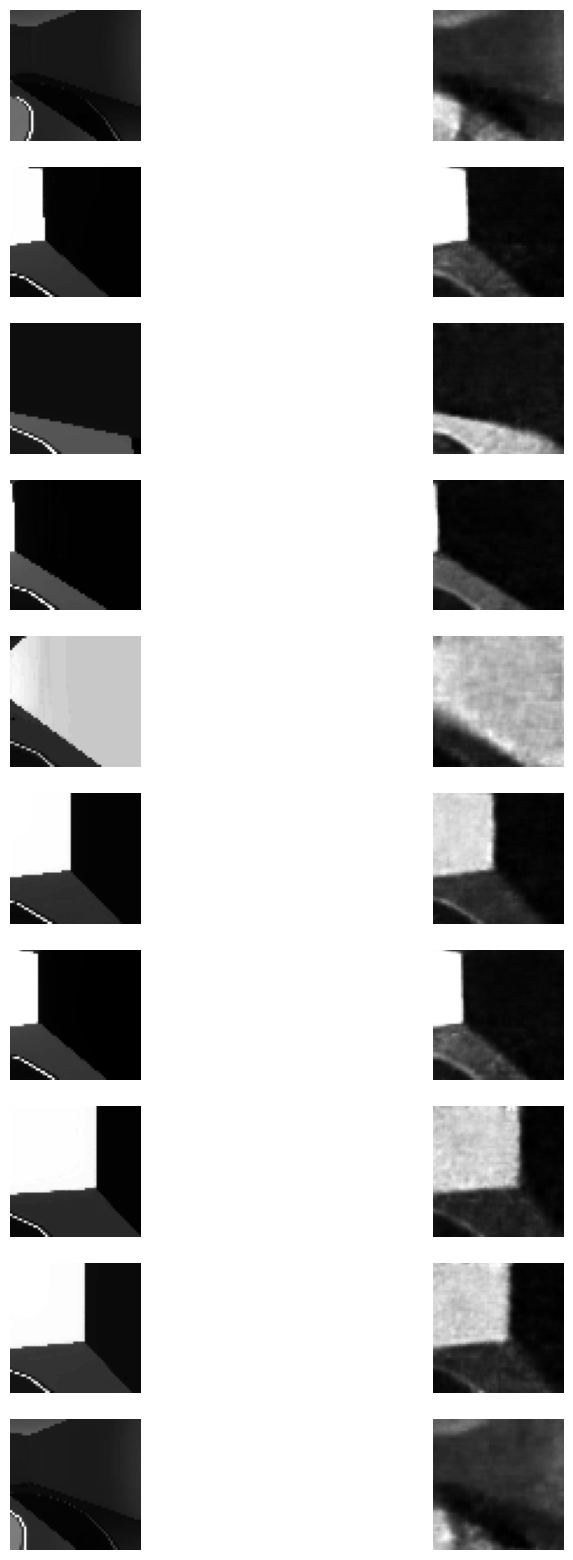

Epoch 14/300
1213/1213 [==============================] - 391s 322ms/step - loss: 1114.4926 - reconstruction_loss: 1095.2814 - kl_loss: 11.7232


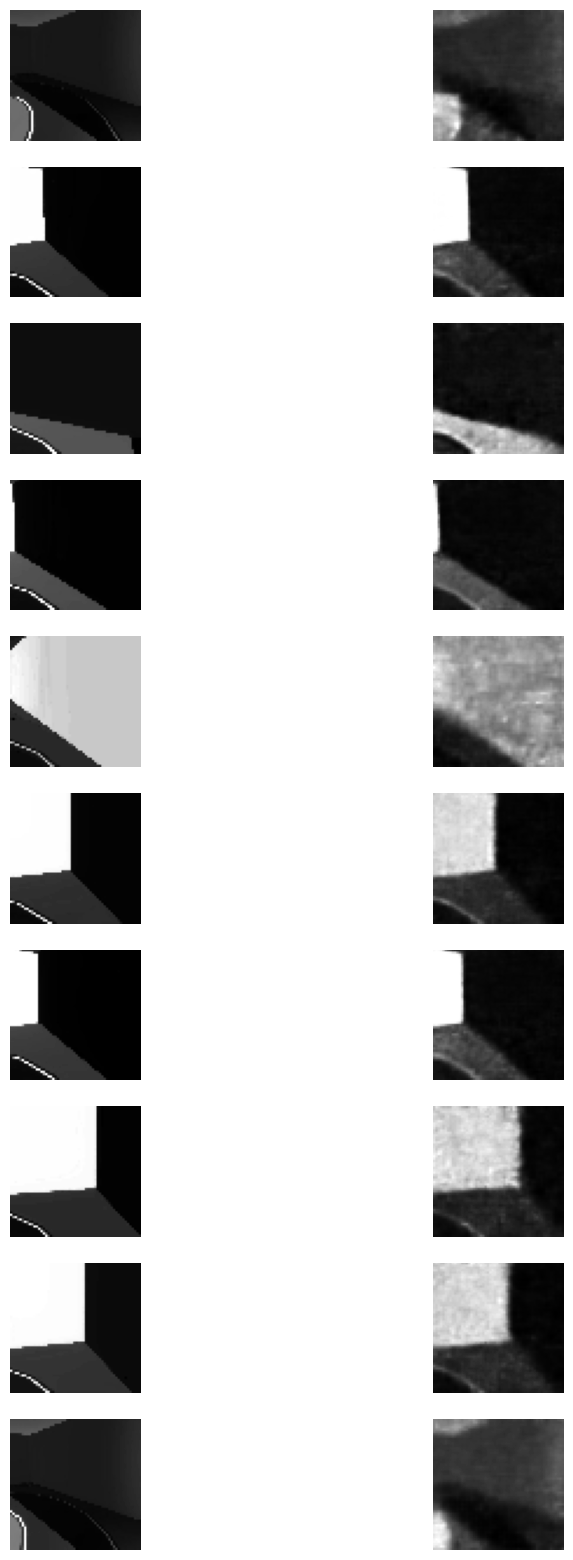

Epoch 15/300
 919/1213 [=====================>........] - ETA: 1:38 - loss: 1116.1149 - reconstruction_loss: 1098.3339 - kl_loss: 11.6964

KeyboardInterrupt: 

In [26]:


history = vae.fit(dataset, epochs=300, callbacks=[vae_callback])

In [23]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 32)   320         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3136)         0           conv2d_5[0][0]                   
____________________________________________________________________________________________

In [24]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3136)              18816     
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 28, 28, 1)         289       
Total params: 74,497
Trainable params: 74,497
Non-trainable params: 0
_______________________________________________________

In [27]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
mnist_digits.shape

(70000, 28, 28, 1)